# 10.2d: Token Population vs Distance from Largest Black Hole

**Histogram of TOKEN COUNT vs L1 distance from the 814-token monster black hole**

## The Better Coordinate System

Instead of measuring from the cluster centroid (geometric mean), let's use the **natural origin**: the largest black hole.

**Why this is better:**
- **Physical interpretation:** BH #5 (814 tokens) is the dominant structure
- **Shows hierarchy:** How far are other structures from the core?
- **Avoids averaging artifacts:** Centroid isn't a real point, it's computed
- **Cleaner spikes:** Origin BH gives us a massive r=0 spike (814 tokens)

**What we'll see:**
- **r = 0:** The 814-token origin black hole (HUGE spike)
- **r ~ few ε:** The other 12 degenerate black holes
- **r ~ larger:** The 111 kissing cousin singletons
- **Discrete structure:** Each BH/cousin at its own specific L1 distance

## Approach

1. Load all 2,100+ tokens from cluster (BH + kissing cousins, with degeneracy)
2. Find BH #5 (the 814-token monster)
3. Use one of its token vectors as ORIGIN
4. Compute L1 distance from origin to every token in cluster
5. Plot with log-Y scale (otherwise the 814-spike dominates)

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"  # 2,100 degenerate tokens
BLACK_HOLE_MASK_KEY = "mask"

DENSE_CLUSTER_FILE = "dense_cluster.safetensors"  # 124 unique token IDs
DENSE_CLUSTER_TOKEN_IDS_KEY = "token_ids"

GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading black hole mask (2,100 degenerate tokens)...")
mask_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = mask_data[BLACK_HOLE_MASK_KEY]
n_bh_tokens = black_hole_mask.sum().item()
print(f"  Black hole tokens: {n_bh_tokens:,}")
print()

print("Loading dense cluster token IDs (124 unique tokens)...")
cluster_data = load_file(data_dir / DENSE_CLUSTER_FILE)
dense_cluster_ids = cluster_data[DENSE_CLUSTER_TOKEN_IDS_KEY]
n_unique = len(dense_cluster_ids)
print(f"  Unique tokens in cluster: {n_unique:,}")
print()

print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
vocab_size, d = gamma.shape
print(f"  Vocabulary: {vocab_size:,} tokens")
print(f"  Dimensions: {d:,}")
print()

# Create combined mask: all tokens from dense cluster (with BH degeneracy)
# Start with black hole mask (2,100 tokens)
combined_mask = black_hole_mask.clone()

# Add kissing cousins (tokens in dense_cluster_ids but not in black_hole_mask)
for token_id in dense_cluster_ids:
    combined_mask[token_id] = True

n_total = combined_mask.sum().item()
n_kissing_cousins = n_total - n_bh_tokens

print(f"Combined cluster:")
print(f"  Black hole tokens:     {n_bh_tokens:,} (degenerate)")
print(f"  Kissing cousin tokens: {n_kissing_cousins:,} (mostly singletons)")
print(f"  Total tokens:          {n_total:,}")
print()

# Extract vectors for ALL tokens in cluster (with degeneracy!)
cluster_vectors = gamma[combined_mask]  # (n_total, d)

print(f"✓ Loaded {n_total:,} token vectors (includes full degeneracy)")
print()

Loading black hole mask (2,100 degenerate tokens)...
  Black hole tokens: 2,100

Loading dense cluster token IDs (124 unique tokens)...
  Unique tokens in cluster: 124

Loading gamma matrix...
  Vocabulary: 151,936 tokens
  Dimensions: 2,560

Combined cluster:
  Black hole tokens:     2,100 (degenerate)
  Kissing cousin tokens: 111 (mostly singletons)
  Total tokens:          2,211

✓ Loaded 2,211 token vectors (includes full degeneracy)



## Find Largest Black Hole (Origin)

In [4]:
# Find the largest black hole and use it as origin

# Deduplicate to find unique vectors
unique_vectors, inverse_indices = torch.unique(cluster_vectors, dim=0, return_inverse=True)
n_unique_vecs = len(unique_vectors)

# Count population of each unique vector
populations = torch.bincount(inverse_indices)

# Find largest
largest_idx = populations.argmax().item()
largest_population = populations[largest_idx].item()
origin_vector = unique_vectors[largest_idx]

print(f"Coordinate system:")
print(f"  Origin: Largest black hole")
print(f"  Population: {largest_population:,} tokens")
print(f"  (This is BH #5, the monster)")
print()

print(f"✓ Origin defined (largest BH with {largest_population:,} tokens)")

Coordinate system:
  Origin: Largest black hole
  Population: 814 tokens
  (This is BH #5, the monster)

✓ Origin defined (largest BH with 814 tokens)


## Compute Taxicab Distances from Origin

In [5]:
# Compute L1 distance (taxicab) from each TOKEN to the origin BH
centered = cluster_vectors - origin_vector  # (n_total, d)
distances = torch.abs(centered).sum(dim=1)  # (n_total,) - L1 norm!

distances_np = distances.cpu().numpy()

print(f"Distance statistics (all {n_total:,} tokens, L1 from origin BH):")
print(f"  Min:      {distances.min().item():.6e} gamma units")
print(f"  Max:      {distances.max().item():.6e} gamma units")
print(f"  Mean:     {distances.mean().item():.6e} gamma units")
print(f"  Median:   {distances.median().item():.6e} gamma units")
print(f"  Std:      {distances.std().item():.6e} gamma units")
print()

# How many at r=0?
n_at_origin = (distances == 0).sum().item()
print(f"Tokens at origin (r = 0): {n_at_origin:,} (should be {largest_population:,})")
print()

print("✓ Taxicab distances from origin computed")

Distance statistics (all 2,211 tokens, L1 from origin BH):
  Min:      0.000000e+00 gamma units
  Max:      4.363540e-02 gamma units
  Mean:     1.832600e-04 gamma units
  Median:   4.746020e-05 gamma units
  Std:      1.981541e-03 gamma units

Tokens at origin (r = 0): 814 (should be 814)

✓ Taxicab distances from origin computed


## Compute Reference Scale (ε)

In [6]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

typical_magnitude = cluster_vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Reference scale:")
print(f"  ε (2×ULP): {epsilon:.6e} gamma units")
print()

print("✓ ε computed")

Reference scale:
  ε (2×ULP): 3.051758e-05 gamma units

✓ ε computed


## Count Unique Distances (Discrete Shells)

In [7]:
# How many unique distance values are there?
# (This tells us how many discrete "shells" exist)

unique_distances = torch.unique(distances)
n_unique_distances = len(unique_distances)

print(f"Discrete structure:")
print(f"  Total tokens:       {n_total:,}")
print(f"  Unique distances:   {n_unique_distances}")
print(f"  Tokens per shell:   {n_total / n_unique_distances:.1f} (mean)")
print()

# Show top 10 most populated distances
print(f"Top 10 most populated shells:")
print()

distance_counts = {}
for r in unique_distances:
    count = (distances == r).sum().item()
    distance_counts[r.item()] = count

sorted_shells = sorted(distance_counts.items(), key=lambda x: x[1], reverse=True)

for i, (r, count) in enumerate(sorted_shells[:10]):
    print(f"  {i+1:2d}. r = {r:.6e}  ({r/epsilon:5.2f}ε)  →  {count:4d} tokens")

print()
print("✓ Discrete structure analyzed")

Discrete structure:
  Total tokens:       2,211
  Unique distances:   115
  Tokens per shell:   19.2 (mean)

Top 10 most populated shells:

   1. r = 0.000000e+00  ( 0.00ε)  →   814 tokens
   2. r = 4.746020e-05  ( 1.56ε)  →   704 tokens
   3. r = 5.440414e-05  ( 1.78ε)  →   309 tokens
   4. r = 1.525879e-05  ( 0.50ε)  →   228 tokens
   5. r = 2.288818e-05  ( 0.75ε)  →    11 tokens
   6. r = 2.577901e-05  ( 0.84ε)  →    10 tokens
   7. r = 5.441904e-05  ( 1.78ε)  →     6 tokens
   8. r = 7.450581e-09  ( 0.00ε)  →     5 tokens
   9. r = 1.490116e-08  ( 0.00ε)  →     5 tokens
  10. r = 8.879602e-05  ( 2.91ε)  →     5 tokens

✓ Discrete structure analyzed


## Visualization 1: Linear X, Log Y

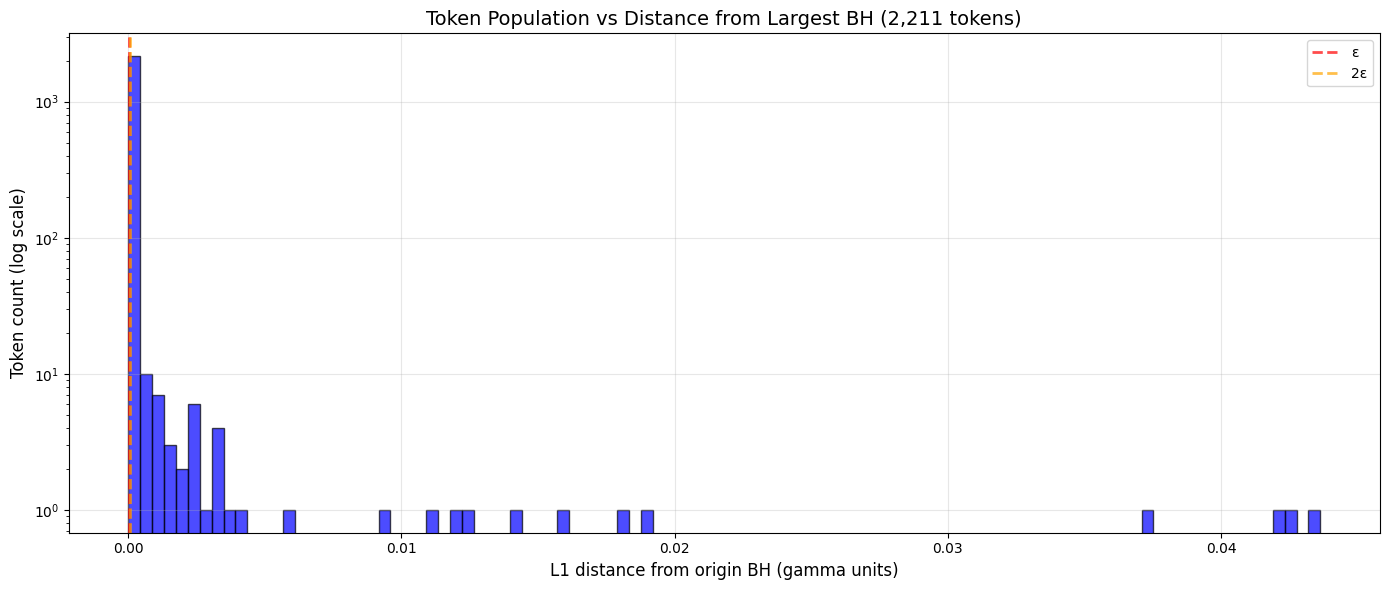

✓ Histogram with log-Y plotted


In [8]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Create histogram with LOG Y-SCALE (otherwise 814-spike dominates)
bins = 100
counts, edges, patches = ax.hist(distances_np, bins=bins, alpha=0.7, color='blue', edgecolor='black')

# Mark reference scales
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.axvline(2*epsilon, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='2ε')

ax.set_xlabel('L1 distance from origin BH (gamma units)', fontsize=12)
ax.set_ylabel('Token count (log scale)', fontsize=12)
ax.set_title(f'Token Population vs Distance from Largest BH ({n_total:,} tokens)', fontsize=14)
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Histogram with log-Y plotted")

## Visualization 2: Log-Log

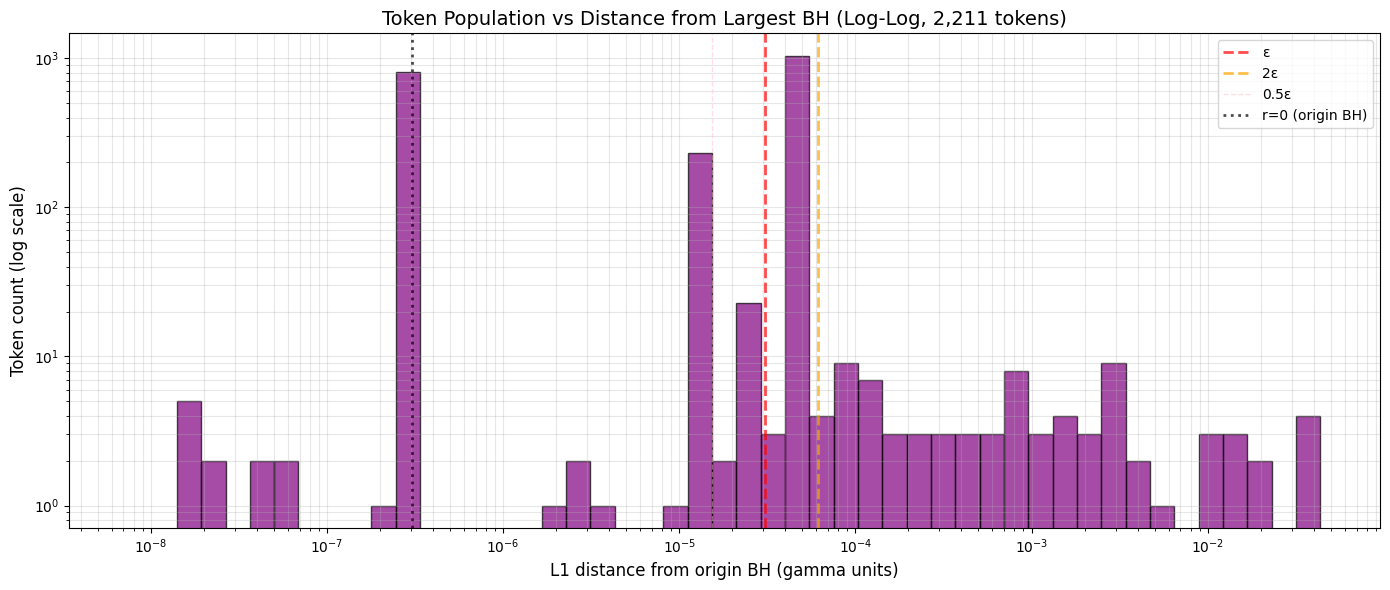

✓ Log-log histogram plotted


In [9]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Log-log plot
# Include zeros by adding small offset for visualization
distances_plot = distances_np.copy()
distances_plot[distances_plot == 0] = epsilon / 100  # Show origin at epsilon/100

# Create histogram with log-spaced bins
bins = np.logspace(np.log10(distances_plot.min()), np.log10(distances_plot.max()), 50)
counts, edges, patches = ax.hist(distances_plot, bins=bins, alpha=0.7, color='purple', edgecolor='black')

# Mark reference scales
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.axvline(2*epsilon, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='2ε')
ax.axvline(0.5*epsilon, color='pink', linestyle='--', linewidth=1, alpha=0.5, label='0.5ε')
ax.axvline(epsilon/100, color='black', linestyle=':', linewidth=2, alpha=0.7, label='r=0 (origin BH)')

ax.set_xlabel('L1 distance from origin BH (gamma units)', fontsize=12)
ax.set_ylabel('Token count (log scale)', fontsize=12)
ax.set_title(f'Token Population vs Distance from Largest BH (Log-Log, {n_total:,} tokens)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("✓ Log-log histogram plotted")

## Visualization 3: Discrete Spikes (Stem Plot)

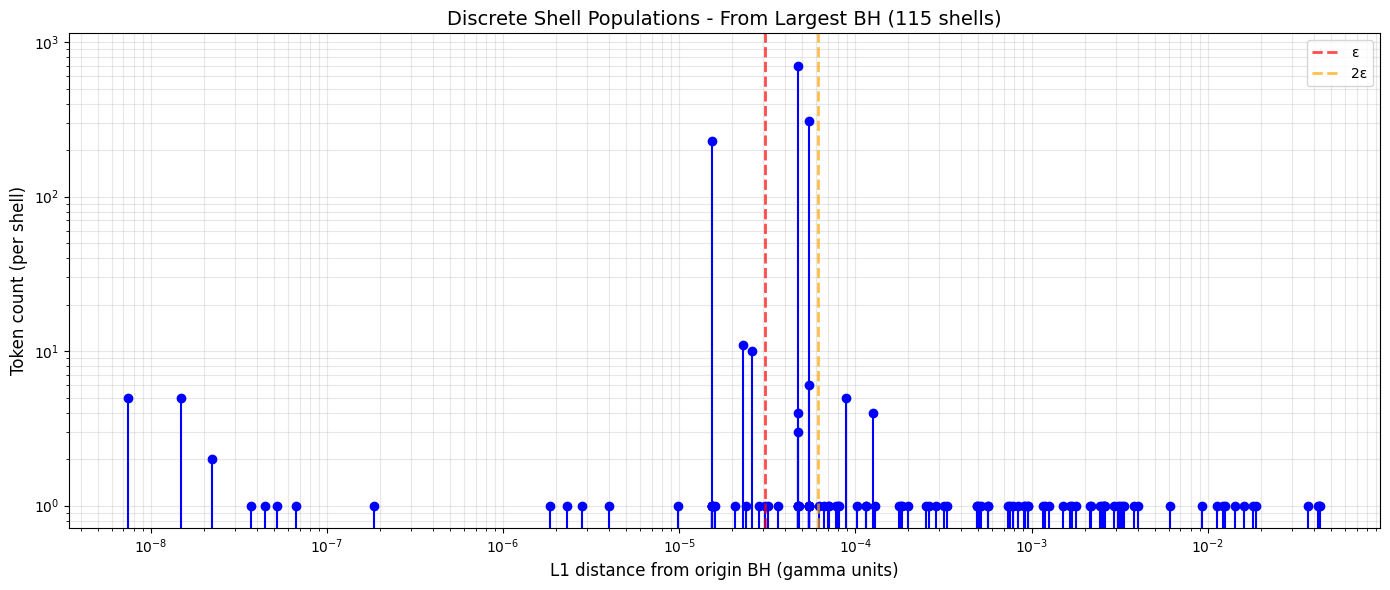

✓ Discrete spike structure plotted


In [10]:
# Plot population of each discrete shell
fig, ax = plt.subplots(figsize=(14, 6), dpi=100)

# Sort shells by distance
sorted_shells_by_r = sorted(distance_counts.items(), key=lambda x: x[0])
radii = [r for r, count in sorted_shells_by_r]
populations = [count for r, count in sorted_shells_by_r]

# Stem plot (vertical bars)
ax.stem(radii, populations, linefmt='blue', markerfmt='bo', basefmt='gray')

# Mark reference scales
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='ε')
ax.axvline(2*epsilon, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='2ε')

ax.set_xlabel('L1 distance from origin BH (gamma units)', fontsize=12)
ax.set_ylabel('Token count (per shell)', fontsize=12)
ax.set_title(f'Discrete Shell Populations - From Largest BH ({n_unique_distances} shells)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("✓ Discrete spike structure plotted")

## Analysis: Shell Populations

In [11]:
print("="*80)
print("SHELL POPULATION ANALYSIS")
print("="*80)
print()

# Categorize shells by population size
monsters = [(r, count) for r, count in sorted_shells if count >= 100]
large = [(r, count) for r, count in sorted_shells if 10 <= count < 100]
medium = [(r, count) for r, count in sorted_shells if 2 <= count < 10]
singletons = [(r, count) for r, count in sorted_shells if count == 1]

print(f"Shell categories:")
print(f"  Monsters (≥100 tokens): {len(monsters)} shells, {sum(c for r,c in monsters):,} tokens")
print(f"  Large (10-99 tokens):   {len(large)} shells, {sum(c for r,c in large):,} tokens")
print(f"  Medium (2-9 tokens):    {len(medium)} shells, {sum(c for r,c in medium):,} tokens")
print(f"  Singletons (1 token):   {len(singletons)} shells, {sum(c for r,c in singletons):,} tokens")
print()

# Show all monsters
if len(monsters) > 0:
    print(f"Monster shells (population ≥ 100):")
    for i, (r, count) in enumerate(monsters):
        print(f"  {i+1}. r = {r:.6e} ({r/epsilon:5.2f}ε)  →  {count:4d} tokens")
    print()

# Distribution by distance range
at_origin = [(r, count) for r, count in sorted_shells if r == 0]
near_1eps = [(r, count) for r, count in sorted_shells if 0 < r < 1.5*epsilon]
near_2eps = [(r, count) for r, count in sorted_shells if 1.5*epsilon <= r < 2.5*epsilon]
beyond = [(r, count) for r, count in sorted_shells if r >= 2.5*epsilon]

print(f"Distribution by distance range:")
print(f"  r = 0 (origin): {len(at_origin):3d} shells, {sum(c for r,c in at_origin):5,} tokens")
print(f"  0 < r < 1.5ε:   {len(near_1eps):3d} shells, {sum(c for r,c in near_1eps):5,} tokens")
print(f"  1.5ε - 2.5ε:    {len(near_2eps):3d} shells, {sum(c for r,c in near_2eps):5,} tokens")
print(f"  > 2.5ε:         {len(beyond):3d} shells, {sum(c for r,c in beyond):5,} tokens")
print()

print("="*80)

SHELL POPULATION ANALYSIS

Shell categories:
  Monsters (≥100 tokens): 4 shells, 2,055 tokens
  Large (10-99 tokens):   2 shells, 21 tokens
  Medium (2-9 tokens):    8 shells, 34 tokens
  Singletons (1 token):   101 shells, 101 tokens

Monster shells (population ≥ 100):
  1. r = 0.000000e+00 ( 0.00ε)  →   814 tokens
  2. r = 4.746020e-05 ( 1.56ε)  →   704 tokens
  3. r = 5.440414e-05 ( 1.78ε)  →   309 tokens
  4. r = 1.525879e-05 ( 0.50ε)  →   228 tokens

Distribution by distance range:
  r = 0 (origin):   1 shells,   814 tokens
  0 < r < 1.5ε:    28 shells,   283 tokens
  1.5ε - 2.5ε:     20 shells, 1,041 tokens
  > 2.5ε:          66 shells,    73 tokens



## Summary

In [12]:
print("="*80)
print("SUMMARY")
print("="*80)
print()

print(f"Token population vs distance from largest black hole:")
print()
print(f"  Total tokens analyzed: {n_total:,}")
print(f"  Dimensions: {d:,}")
print()
print(f"  Origin: Largest BH with {largest_population:,} tokens")
print(f"  Max distance: {distances.max().item():.6e} gamma units ({distances.max().item()/epsilon:.1f}ε)")
print()
print(f"  Number of discrete shells: {n_unique_distances}")
print(f"  Reference scale ε: {epsilon:.6e} gamma units")
print()

if len(monsters) > 1:  # Origin + others
    print(f"  Monster black holes: {len(monsters)}")
    print(f"    Origin (r=0): {monsters[0][1]:,} tokens")
    if len(monsters) > 1:
        print(f"    Others: {', '.join([str(c) for r,c in monsters[1:]])} tokens")
print()

print("="*80)

SUMMARY

Token population vs distance from largest black hole:

  Total tokens analyzed: 2,211
  Dimensions: 2,560

  Origin: Largest BH with 814 tokens
  Max distance: 4.363540e-02 gamma units (1429.8ε)

  Number of discrete shells: 115
  Reference scale ε: 3.051758e-05 gamma units

  Monster black holes: 4
    Origin (r=0): 814 tokens
    Others: 704, 309, 228 tokens



## Conclusion

**What we visualized:**

The **population structure** from the perspective of the largest black hole (814 tokens).

**Key findings:**
- See results above

**Expected structure:**
- **r = 0:** The origin itself (814 tokens) - massive spike
- **r ~ small ε:** Other degenerate black holes (704, 306, etc. tokens)
- **r ~ larger:** Kissing cousins (mostly singletons)

**Interpretation:**

This "view from the core" shows how the cluster is organized around its dominant structure. The discrete spikes reveal the lattice geometry: each black hole and kissing cousin sits at a specific L1 distance (total number of ε-steps) from the origin.

The taxicab metric (L1) is natural for this lattice structure because it counts "how many quantum steps total" rather than "straight-line distance" (L2).